In [1]:
import sys
import argparse
import random
from pipeline_if import IFPipeline
from pipeline_if_superresolution import IFSuperResolutionPipeline
from diffusers.utils import pt_to_pil
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils
from utils import get_Afuncs
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

import logging
import importlib
import numpy as np

C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Sat Mar 15 01:27:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.47                 Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P4             11W /   40W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
stage_1 = IFPipeline.from_pretrained("DeepFloyd/IF-I-XL-v1.0", variant="fp16", torch_dtype=torch.float16)
#stage_1.enable_xformers_memory_efficient_attention()  # remove line if torch.__version__ >= 2.0.0
stage_1.enable_model_cpu_offload()

# stage 2
stage_2 = IFSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", torch_dtype=torch.float16
)
#stage_2.enable_xformers_memory_efficient_attention()  # remove line if torch.__version__ >= 2.0.0
stage_2.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]
C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\diffusers\loaders\lora_pipeline.py:3811: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)

A mixture of fp16 and non-fp16 filenames will b

In [4]:
scale = 16 #upsampling facctor
dec_steps = 100 #number of decoder inference steps in 1st stage
sr_steps = 50 #number of inference steps
guidance_scale_stage1 = 7.0 #classifier free guidance parameter in 1st stage imagen diffusion, no cfg value<=1
guidance_scale_stage2 =4.0 #classifier free guidance in 2nd stage (SR stage) in imagen, no cgf if this value<=1

In [ ]:
#Setting up Consistency enforcement 
Av=get_Afuncs('sr_bicubic',sizes=256,sr_scale=scale) 
A = Av.A
Ap = Av.A_pinv

In [ ]:
        
        
        
gt_t = Image.open('highres.png')
gt_t = utils.from_pil_image(gt_t)[:3,:,:]   

#bicubic downsampling, generate LR observation
lrf = A(gt_t.detach().unsqueeze(0).cuda()).reshape(1,3,256//scale,256//scale)
plt.imsave(f'LRx{scale}.png',(0.5+0.5*lrf[0]).detach().cpu().permute(1,2,0).clip(0,1.0).numpy())
lrf = lrf.half()


In [ ]:

caption = 'a smiling woman'
prompt = 'A professional realistic high-res portrait face photograph' + caption
negative_prompt = 'disfigured,blurred, ugly, bad, immature, bad teeth, caricature, unnatural, wierd lighting, fake'
#embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt = prompt, negative_prompt = negative_prompt)
generator = torch.manual_seed(0) #Optional argument to T2I model,change random seed if results are not satisfactory
# Text guided restoration

#Within pipe stage 1
image = stage_1.sup_res(lr = lrf.detach(),
                        prompt_embeds=prompt_embeds, 
                        negative_prompt_embeds=negative_embeds, 
                        num_inference_steps=dec_steps, 
                        guidance_scale = guidance_scale_stage1, 
                        generator=generator, 
                        output_type="pt", 
                        sr_scale=scale//4,
                        algo = 'ddnm')

#pipe stage 2
imagesr = stage_2.sup_res(image=image,
                            lr = lrf.detach(),
                            sr_scale=scale//4, 
                            prompt_embeds=prompt_embeds,
                            negative_prompt_embeds=negative_embeds,  
                            num_inference_steps=sr_steps, 
                            guidance_scale = guidance_scale_stage2, 
                            generator=generator, output_type="pt",
                            algo = 'ddnm')


starting from
tensor(990, device='cuda:0')


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\diffusers\models\attention_processor.py:1383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 50/50 [01:59<00:00,  2.40s/it]


In [8]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


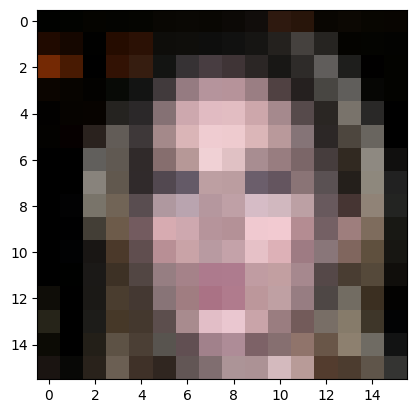

In [9]:
plt.imshow(0.5*(1+lrf[0]).permute(1,2,0).float().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


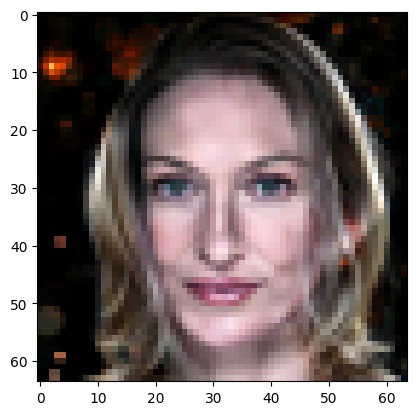

In [10]:
plt.imshow(0.5*(image[0]+1).permute(1,2,0).cpu().float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


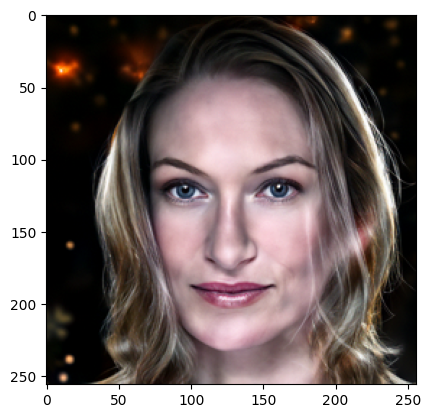

In [11]:
plt.imshow(0.5*(imagesr.images[0]+1).permute(1,2,0).cpu().float())

In [12]:
lrfo=A(imagesr.images[0].unsqueeze(0).float())
lrpsnr=-10*torch.log10(torch.nn.functional.mse_loss(lrf[0].reshape(1,-1),lrfo[0]))
print(lrpsnr)

tensor(65.5553, device='cuda:0')


C:\Users\manis\AppData\Local\Temp\ipykernel_23268\2601744253.py:2: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([1, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  lrpsnr=-10*torch.log10(torch.nn.functional.mse_loss(lrf[0].reshape(1,-1),lrfo[0]))


In [13]:
caption = 'a woman with curly hair'
prompt = 'A professional realistic high-res portrait face photograph' + caption
negative_prompt = 'disfigured,blurred, ugly, bad, immature, bad teeth, caricature, unnatural, wierd lighting, fake'
#embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt = prompt, negative_prompt = negative_prompt)
generator = torch.manual_seed(10) #Optional argument to T2I model,change random seed if results are not satisfactory
# Text guided restoration

                
#Within pipe stage 1
image = stage_1.sup_res(lr = lrf.detach(),
                        prompt_embeds=prompt_embeds, 
                        negative_prompt_embeds=negative_embeds, 
                        num_inference_steps=dec_steps, 
                        guidance_scale = guidance_scale_stage1, 
                        generator=generator, 
                        output_type="pt", 
                        sr_scale=scale//4,
                        algo = 'ddnm')
                
#pipe stage 2
imagesr = stage_2.sup_res(image=image,
                          lr = lrf.detach(),
                          sr_scale=scale//4, 
                          prompt_embeds=prompt_embeds,
                          negative_prompt_embeds=negative_embeds,  
                          num_inference_steps=sr_steps, 
                          guidance_scale = guidance_scale_stage2, 
                          generator=generator, output_type="pt",
                        algo = 'ddnm')

starting from
tensor(990, device='cuda:0')


100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


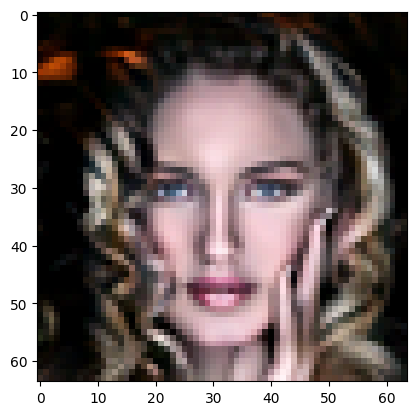

In [14]:
plt.imshow(0.5*(image[0]+1).permute(1,2,0).cpu().float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


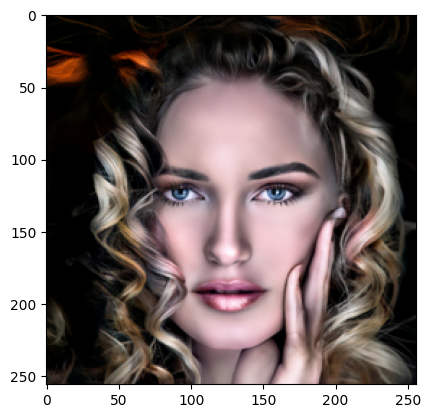

In [15]:
plt.imshow(0.5*(imagesr.images[0]+1).permute(1,2,0).cpu().float())

In [16]:
lrfo=A(imagesr.images[0].unsqueeze(0).float())
lrpsnr=-10*torch.log10(torch.nn.functional.mse_loss(lrf[0].reshape(1,-1),lrfo[0]))
print(lrpsnr)

C:\Users\manis\AppData\Local\Temp\ipykernel_23268\2601744253.py:2: UserWarning: Using a target size (torch.Size([768])) that is different to the input size (torch.Size([1, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  lrpsnr=-10*torch.log10(torch.nn.functional.mse_loss(lrf[0].reshape(1,-1),lrfo[0]))


tensor(65.1306, device='cuda:0')


In [17]:
caption = 'a woman with glasses'
prompt = 'A professional realistic high-res portrait face photograph' + caption
negative_prompt = 'disfigured,blurred, ugly, bad, immature, bad teeth, caricature, unnatural, wierd lighting, fake'
#embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt = prompt, negative_prompt = negative_prompt)
generator = torch.manual_seed(100) #Optional argument to T2I model,change random seed if results are not satisfactory
# Text guided restoration
                
#Within pipe stage 1
image = stage_1.sup_res(lr = lrf.detach(),
                        prompt_embeds=prompt_embeds, 
                        negative_prompt_embeds=negative_embeds, 
                        num_inference_steps=dec_steps, 
                        guidance_scale = guidance_scale_stage1, 
                        generator=generator, 
                        output_type="pt", 
                        sr_scale=scale//4,
                        algo = 'ddnm')
                
#pipe stage 2
imagesr = stage_2.sup_res(image=image,
                          lr = lrf.detach(),
                          sr_scale=scale//4, 
                          prompt_embeds=prompt_embeds,
                          negative_prompt_embeds=negative_embeds,  
                          num_inference_steps=sr_steps, 
                          guidance_scale = guidance_scale_stage2, 
                          generator=generator, output_type="pt",
                          algo = 'ddnm')

starting from
tensor(990, device='cuda:0')


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


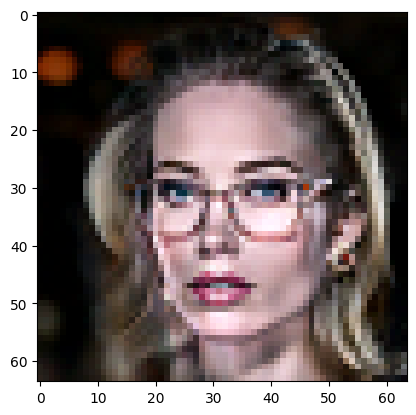

In [18]:
plt.imshow(0.5*(image[0]+1).permute(1,2,0).cpu().float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


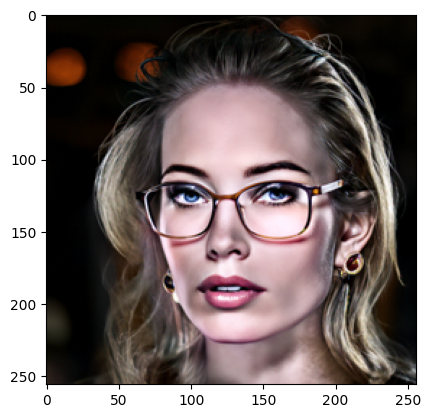

In [19]:
plt.imshow(0.5*(imagesr.images[0]+1).permute(1,2,0).cpu().float())